In [335]:
device = "mps"

# Cats and Dogs dataset

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import datasets
from PIL import Image
import numpy as np

def get_catdog_dataloaders(batch_size_train, batch_size_test=32):
    ds = datasets.load_dataset("microsoft/cats_vs_dogs")
    def transform(images, target_size):
        # thresh = 128  # Threshold for binarization
        # fn = lambda x : 255 if x > thresh else 0
        #return [i.convert('L').point(fn, mode='1').resize(target_size, Image.NEAREST) for i in images]
        return [i.convert('L').resize(target_size, Image.NEAREST) for i in images]
    rescaled_ds = ds["train"].map(lambda x: {"image": transform(x["image"], (60,60))},
                        batched=True, batch_size=128, num_proc=12)
    imgs = torch.tensor(np.array(rescaled_ds["image"]), dtype=torch.float32, device=device).flatten(start_dim=1)
    imgs = imgs / 255.0
    # Remove the mean and std
    imgs = (imgs - imgs.mean(dim=1, keepdim=True)) / (imgs.std(dim=1, keepdim=True) + 1e-6)
    labels = torch.tensor(rescaled_ds["labels"], dtype=torch.int64, device=device).flatten()
    # Count number of each label
    num_cats = (labels == 0).sum().item()
    num_dogs = (labels == 1).sum().item()
    print(f"Number of cats: {num_cats}")
    print(f"Number of dogs: {num_dogs}")
    ds = TensorDataset(imgs, labels)
    train_set, test_set = random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.2)])
    train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = get_catdog_dataloaders(32)

Number of cats: 11741
Number of dogs: 11669


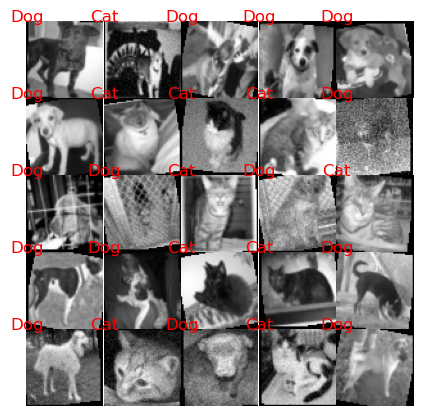

In [401]:
import matplotlib.pyplot as plt
import numpy as np
def show_examples(dataset):
    plt.figure(figsize=(5, 5))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        ii = np.random.randint(0, len(dataset))
        img = dataset[ii][0].cpu()
        size = img.shape[0]**0.5
        img = img.reshape((int(size), int(size))).numpy()
        plt.imshow(img, cmap="gray")
        label = "Cat" if dataset[ii][1] == 0 else "Dog"
        plt.text(0, 0, label, fontsize=12, ha='center', color='red')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

show_examples(train_loader.dataset)

In [399]:
print(train_loader.dataset[0][0])

tensor([-0.4542, -0.1915, -0.1633,  ..., -2.4245, -2.2283, -2.4150],
       device='mps:0')


# MNIST dataset

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset

def get_mnist_dataloaders(
    batch_size_train: int = 256,
    batch_size_test: int = 1024,
):
    ds = load_dataset("mnist")
    def preprocess_batch(batch):
        arr = np.stack([np.array(img, dtype=np.float32) for img in batch["image"]])
        arr = arr[:, None, :, :] / 255.0
        batch["pixel_values"] = arr.astype(np.float32)
        return batch
    ds = ds.map(preprocess_batch, batched=True, batch_size=1024, num_proc=12, desc="Preprocessing MNIST")

    train = ds["train"][:]
    test  = ds["test"][:]
    def to_torch(img, lbl):
        img = torch.tensor(img).flatten(start_dim=1).to(device)
        lbl = torch.tensor(lbl, dtype=torch.long,device=device)
        return TensorDataset(img, lbl)


    train_loader = DataLoader(
        to_torch(train["pixel_values"], train["label"]),
        batch_size=batch_size_train,
        shuffle=True,
    )
    test_loader = DataLoader(
        to_torch(test["pixel_values"], test["label"]),
        batch_size=batch_size_test,
        shuffle=False,
    )
    return train_loader, test_loader


train_loader, test_loader = get_mnist_dataloaders(batch_size_train=512, batch_size_test=128)

100%|██████████| 775M/775M [01:21<00:00, 9.94MB/s] 

Extracting files...


Path to dataset files: /Users/raul/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


In [ ]:

import os
import kagglehub
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
def get_catdog_dataloaders(batch_size_train, batch_size_test=32):


        # Download the dataset
    path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
    cat_dir = os.path.join(path, "PetImages", "Cat")
    dog_dir = os.path.join(path, "PetImages", "Dog")

    def load_images_from_dir(dirpath, label):
        imgs, labels = [], []
        for fn in os.listdir(dirpath):
            fp = os.path.join(dirpath, fn)
            try:
                with Image.open(fp) as im:
                    im = im.convert("L").resize((60, 60), Image.NEAREST)
                    arr = np.asarray(im, dtype=np.float32)
                    imgs.append(arr)
                    labels.append(label)
            except Exception:
                # skip unreadable files
                continue
        return imgs, labels

    cat_imgs, cat_labels = load_images_from_dir(cat_dir, 0)
    dog_imgs, dog_labels = load_images_from_dir(dog_dir, 1)

    all_imgs = np.stack(cat_imgs + dog_imgs, axis=0)
    all_labels = np.array(cat_labels + dog_labels, dtype=np.int64)

    # normalize per-image
    all_imgs = all_imgs / 255.0
    means = all_imgs.mean(axis=(1, 2), keepdims=True)
    stds = all_imgs.std(axis=(1, 2), keepdims=True) + 1e-6
    all_imgs = (all_imgs - means) / stds

    # flatten and move to device
    imgs_t = torch.tensor(all_imgs, dtype=torch.float32, device=device).reshape(len(all_imgs), -1)
    labels_t = torch.tensor(all_labels, dtype=torch.long, device=device)

    train_dataset = TensorDataset(imgs_t, labels_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_loader = DataLoader(train_dataset, batch_size=batch_size_test, shuffle=True)
    return train_loader, test_loader
train_loader, test_loader = get_catdog_dataloaders(1024)


In [ ]:
import torch.optim as optim
from tqdm import tqdm
import torch
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout = None):
        super(MLP, self).__init__()
        act = nn.GELU()
        layers = []
        in_features = input_size
        for _ in range(num_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(act)
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_features = hidden_size
        self.features = nn.Sequential(*layers)
        self.head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

def train_model(train_loader, test_loader, number_categories):
    image_size = train_loader.dataset[0][0].numel()
    model = MLP(input_size=image_size, hidden_size=128, num_layers=4, output_size=number_categories, dropout=0.1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    def evaluate_ce(model, dataloader):
        model.eval()
        total_loss, total_correct, total_examples = 0.0, 0, 0
        with torch.no_grad():
            for x, y in dataloader:          
                logits = model(x)
                loss = nn.functional.cross_entropy(logits, y.view(-1).long(), reduction="sum")
                total_loss += loss.item()

                preds = logits.argmax(dim=1)
                total_correct += (preds == y.view(-1).long()).sum().item()
                total_examples += y.size(0)

        mean_loss = total_loss / total_examples
        accuracy = total_correct / total_examples
        return mean_loss, accuracy

    for epoch in (pbar := tqdm(range(50))):
        model.train()
        train_loss = 0.0
        train_examples = 0
        for images, labels in tqdm(train_loader,leave=False):
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels.view(-1).long())
            loss.backward()
            optimizer.step()
            batch_loss = nn.functional.cross_entropy(logits, labels.view(-1).long(), reduction="sum")
            train_loss += batch_loss.item()
            train_examples += labels.size(0)
        model.eval()
        loss, acc = evaluate_ce(model, test_loader)
        pbar.set_description(f"Epoch {epoch + 1}, Train loss: {train_loss / train_examples:.4e}, Test Loss: {loss:.4e}, Acc: {acc:.4e}")
    return model
train_loader, test_loader = get_catdog_dataloaders(1024)
model = train_model(train_loader, test_loader, 2)

/Users/raul/miniforge3/envs/llm/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 50, Train loss: 7.2834e-02, Test Loss: 2.1847e-02, Acc: 9.9620e-01: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


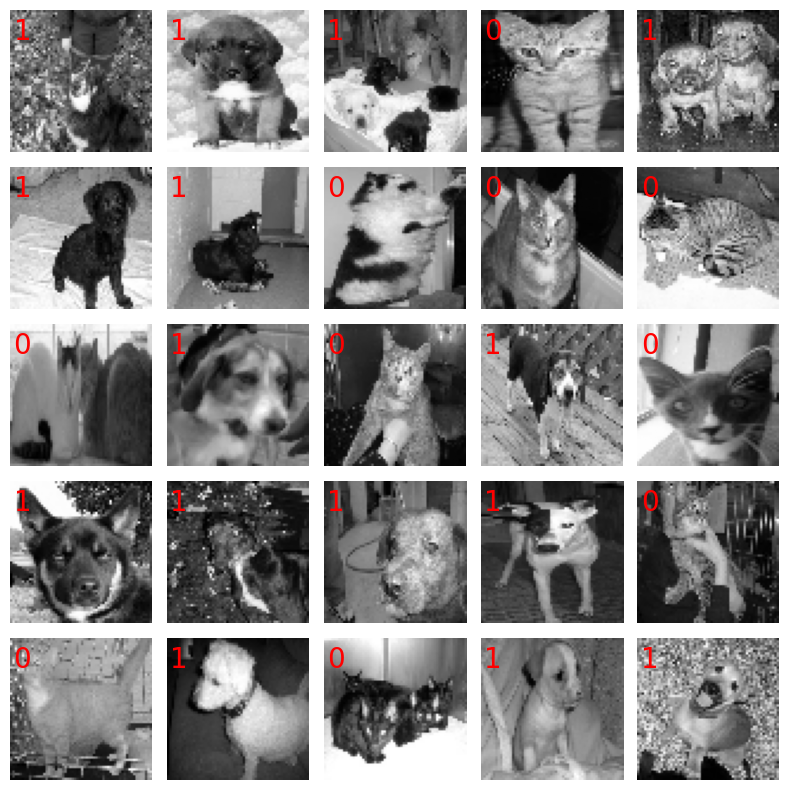

In [434]:
import matplotlib.pyplot as plt
import torch

def visualize_examples(model, dataloader, class_names=None):
    model.eval()
    device = next(model.parameters()).device
    images, labels = next(iter(dataloader))
    with torch.no_grad():
        logits = model(images)
        preds = logits.argmax(dim=1)
    idxs = torch.randperm(images.size(0))[:25]
    plt.figure(figsize=(8,8))
    for i, idx in enumerate(idxs):
        img = images[idx].cpu()
        pred = preds[idx].item()
        if img.ndim == 3 and img.shape[0] == 1:
            img = img.squeeze(0)
        img_size = int(img.numel() ** 0.5)
        img = img.reshape(img_size, img_size).numpy()
        plt.subplot(5,5,i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        pred_str = str(pred) if class_names is None else class_names[pred]
        plt.text(1, 3, pred_str, color="red", fontsize=20, ha="left", va="top")

    plt.tight_layout()
    plt.show()
visualize_examples(model, test_loader)
